# BTC price & movement prediction, Glassnode 2024

## Approaches

- preprocessing: 
  - selecting only float metrics
  - dropping all price columns except one for target
  - check for multicolliniarity & drop values with corr >= 0.95
  - reduce number of features:
    - Reducing shape:
      - `PCA`
      - `t-SNE`, `UMAP`
    <!-- - Option 2: with filter methods:
      - `SelectKBest` + `f_classif`
      - `mutual_info_classif`
      - `Lasso` + `SelectFromModel`
      - `RFE` -->
  - optuna
  - select more important features: ....
- sklearn classification
- sklearn regression
- RNN, LSTM


In [18]:
import pandas as pd
import os
import numpy as np

In [19]:
folder_path = 'glassnode_data_btc'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

## Filtering

In [20]:
dataframes = [pd.read_csv(os.path.join(folder_path, file)) for file in csv_files]
combined_df = pd.concat(dataframes, ignore_index=True)

In [21]:
combined_df.head()

timestamp           v    o balance changes  open_interest  ath_price  \
0  2021-02-16  114.024889  NaN     NaN     NaN            NaN        NaN   
1  2021-02-17  107.220092  NaN     NaN     NaN            NaN        NaN   
2  2021-02-18  100.845519  NaN     NaN     NaN            NaN        NaN   
3  2021-02-19  101.234905  NaN     NaN     NaN            NaN        NaN   
4  2021-02-20   98.642269  NaN     NaN     NaN            NaN        NaN   

   current_price  total_supply partitions volumes  total_volume balances  \
0            NaN           NaN        NaN     NaN           NaN      NaN   
1            NaN           NaN        NaN     NaN           NaN      NaN   
2            NaN           NaN        NaN     NaN           NaN      NaN   
3            NaN           NaN        NaN     NaN           NaN      NaN   
4            NaN           NaN        NaN     NaN           NaN      NaN   

   daily_volume  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

In [22]:
len(dataframes)

669

In [23]:
dataframes = []

for file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    suffix = file[4:].replace('.csv', '')
    df.rename(columns={col: f"{col}_{suffix}" for col in df.columns if col != 'timestamp'}, inplace=True)
    df.set_index('timestamp', inplace=True)
    dataframes.append(df)

combined_df = dataframes[0]
for df in dataframes[1:]:
    combined_df = combined_df.join(df, how='outer')


In [24]:
combined_df = combined_df.loc['2020-01-01':'2024-06-01']

In [25]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1614 entries, 2020-01-01 to 2024-06-01
Columns: 691 entries, v_v1_metrics_derivatives_options_atm_implied_volatility_1_week to v_v1_metrics_entities_active_count
dtypes: float64(566), object(125)
memory usage: 8.5+ MB


In [26]:
df = combined_df.copy(deep=True)

In [27]:
df.head()

v_v1_metrics_derivatives_options_atm_implied_volatility_1_week  \
timestamp                                                                    
2020-01-01                                                NaN                
2020-01-02                                                NaN                
2020-01-03                                                NaN                
2020-01-04                                                NaN                
2020-01-05                                                NaN                

            v_v1_metrics_transactions_transfers_volume_exchanges_net_pit  \
timestamp                                                                  
2020-01-01                                        1037.507591              
2020-01-02                                       -1261.073521              
2020-01-03                                        2230.358147              
2020-01-04                                        1092.685966              
2020-01-05                                        -165.661735              

            v_v1_metrics_indicators_sopr  \
timestamp                                  
2020-01-01                      0.997800   
2020-01-02                      0.996801   
2020-01-03                      1.001081   
2020-01-04                      0.996234   
2020-01-05                      1.001827   

            v_v1_metrics_indicators_realized_loss_to_exchanges_account_based_pit  \
timestamp                                                                          
2020-01-01                                                NaN                      
2020-01-02                                                NaN                      
2020-01-03                                                NaN                      
2020-01-04                                                NaN                      
2020-01-05                                                NaN                      

            v_v1_metrics_distribution_balance_otc_desks_pit  \
timestamp                                                     
2020-01-01                                              NaN   
2020-01-02                                              NaN   
2020-01-03                                              NaN   
2020-01-04                                              NaN   
2020-01-05                                              NaN   

                  o_v1_metrics_breakdowns_sopr_by_wallet_size  \
timestamp                                                       
2020-01-01  {'0001_001': 0.9895968046017839, '001_01': 0.9...   
2020-01-02  {'0001_001': 0.9846696537723294, '001_01': 0.9...   
2020-01-03  {'0001_001': 0.998744520604327, '001_01': 0.99...   
2020-01-04  {'0001_001': 0.9969779371830698, '001_01': 0.9...   
2020-01-05  {'0001_001': 1.00438172946638, '001_01': 1.005...   

                 o_v1_metrics_breakdowns_marketcap_usd_by_age  \
timestamp                                                       
2020-01-01  {'1d_1w': 2317861858.853726, '1m_3m': 10808927...   
2020-01-02  {'1d_1w': 1898039839.9722486, '1m_3m': 1052758...   
2020-01-03  {'1d_1w': 2027456903.4646225, '1m_3m': 1124771...   
2020-01-04  {'1d_1w': 2731276270.2818646, '1m_3m': 1129355...   
2020-01-05  {'1d_1w': 2922423174.6289754, '1m_3m': 1123046...   

            v_v1_metrics_mining_miners_outflow_multiple  \
timestamp                                                 
2020-01-01                                     0.833294   
2020-01-02                                     0.961739   
2020-01-03                                     1.002015   
2020-01-04                                     0.998218   
2020-01-05                                     0.958034   

            v_v1_metrics_institutions_purpose_etf_holdings_sum  \
timestamp                                                        
2020-01-01                                                NaN    
2020-01-02                                                NaN    
20

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [29]:
float_data = df.rename(columns={'v_v1_metrics_market_price_usd_close': 'price'}).select_dtypes(include=['float', 'float64', 'float32'])

## Multicollinearity check

In [30]:
corr_matrix = float_data.drop('price', axis=1).corr().abs()
upper_tri =  corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# todo: will it remove two columns or only one?
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.95)]

print(f'Количество признаков перед удалением: {float_data.shape[1]}')
print(f'Количество признаков для удаления: {len(to_drop)}')
print(f'Признаки, подлежащие удалению: {to_drop}')

Количество признаков перед удалением: 566
Количество признаков для удаления: 243
Признаки, подлежащие удалению: ['v_v1_metrics_indicators_nupl_more_155_account_based_pit', 'v_v1_metrics_distribution_balance_blackrock', 'v_v1_metrics_entities_supply_balance_less_0001', 'v_v1_metrics_entities_supply_balance_10_100_pit', 'v_v1_metrics_entities_supply_balance_001_01_pit', 'v_v1_metrics_transactions_transfers_volume_entity_adjusted_median', 'total_supply_v1_metrics_indicators_utxo_realized_price_distribution_ath', 'v_v1_metrics_entities_supply_balance_1k_10k_pit', 'v_v1_metrics_supply_inflation_rate', 'v_v1_metrics_market_spot_volume_daily_sum', 'v_v1_metrics_supply_sth_sum', 'v_v1_metrics_indicators_unrealized_loss_account_based', 'ath_price_v1_metrics_indicators_urpd_entity_adjusted_pit', 'current_price_v1_metrics_indicators_urpd_entity_adjusted_pit', 'total_supply_v1_metrics_indicators_urpd_entity_adjusted_pit', 'v_v1_metrics_distribution_balance_wbtc_pit', 'v_v1_metrics_addresses_supply

In [31]:
float_data = float_data.drop(columns=to_drop)

In [32]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

## Drop NaN cols, Create `price_up` boolean feature

In [33]:
if 'price_up' not in float_data.columns:
    if 'price' in float_data.columns:
        # Создаем 'price_up': 1 если цена на следующий день выше текущей, иначе 0
        float_data['price_up'] = (float_data['price'].shift(-1) > float_data['price']).astype(int)
        float_data = float_data.dropna(subset=['price_up'])  # Удаление строк с NaN в 'price_up'
    else:
        raise ValueError("DataFrame должен содержать колонку 'price', чтобы создать 'price_up'.")

# Проверка уникальных значений в целевой переменной
print("Распределение классов 'price_up':")
print(float_data['price_up'].value_counts())

X = float_data.drop(columns=['price', 'price_up'])
y = float_data['price_up'] 

print(f"Форма X: {X.shape}")
print(f"Форма y: {y.shape}")

# 4. Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # shuffle=False для временных рядов
)

print(f"Форма X_train: {X_train.shape}")
print(f"Форма X_test: {X_test.shape}")

###### WHY????

# 5. Обнаружение и удаление колонок с всеми NaN в тренировочном наборе
# Проверим, есть ли такие колонки
cols_all_nan = X_train.columns[X_train.isnull().all()].tolist()
print(f"Колонки с всеми NaN в X_train: {cols_all_nan}")

# Удалим эти колонки из тренировочного и тестового наборов
if cols_all_nan:
    X_train = X_train.drop(columns=cols_all_nan)
    X_test = X_test.drop(columns=cols_all_nan)
    print(f"После удаления колонок с всеми NaN, форма X_train: {X_train.shape}")
    print(f"После удаления колонок с всеми NaN, форма X_test: {X_test.shape}")
else:
    print("Нет колонок с всеми NaN в X_train.")

Распределение классов 'price_up':
price_up
1    823
0    791
Name: count, dtype: int64
Форма X: (1614, 322)
Форма y: (1614,)
Форма X_train: (1291, 322)
Форма X_test: (323, 322)
Колонки с всеми NaN в X_train: ['changes_v1_metrics_derivatives_futures_open_interest_latest', 'open_interest_v1_metrics_derivatives_futures_open_interest_latest', 'v_v1_metrics_distribution_balance_german_government_pit', 'v_v1_metrics_transactions_runes_fee_share', 'v_v1_metrics_institutions_us_spot_etf_flows_net', 'changes_v1_metrics_derivatives_futures_volume_daily_latest', 'daily_volume_v1_metrics_derivatives_futures_volume_daily_latest', 'v_v1_metrics_distribution_balance_us_government_pit']
После удаления колонок с всеми NaN, форма X_train: (1291, 314)
После удаления колонок с всеми NaN, форма X_test: (323, 314)


## Fill Missing Values & Scale them

In [34]:
# KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=X_test.index)

# Проверка на наличие пропусков после импутации
print("Пропуски в тренировочных данных после импутации:", X_train_imputed.isnull().sum().sum())
print("Пропуски в тестовых данных после импутации:", X_test_imputed.isnull().sum().sum())

# StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_imputed)  

X_train_scaled = scaler.transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

Пропуски в тренировочных данных после импутации: 0
Пропуски в тестовых данных после импутации: 0


## PCA

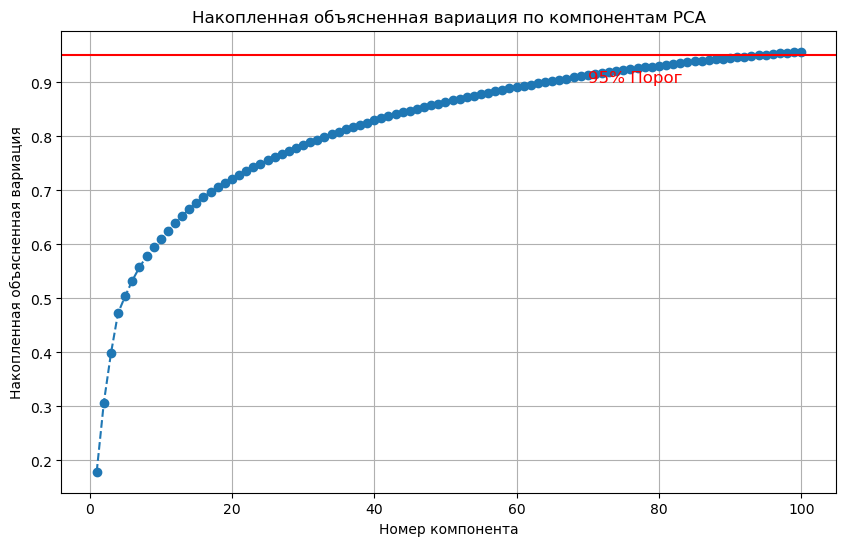

Форма X_train_pca: (1291, 100)
Форма X_test_pca: (323, 100)


In [35]:
# todo: переписать так, чтобы это значение автоматически находилось от заданного персентиля
n_components = 100  # Вы можете настроить это значение

pca = PCA(n_components=n_components, random_state=42)
pca.fit(X_train_scaled)  # Обучение PCA на тренировочных данных

# Преобразование тренировочных и тестовых данных
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Преобразование в DataFrame для удобства (опционально)
pca_columns = [f'PC{i}' for i in range(1, n_components + 1)]
X_train_pca = pd.DataFrame(X_train_pca, columns=pca_columns, index=X_train.index)
X_test_pca = pd.DataFrame(X_test_pca, columns=pca_columns, index=X_test.index)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Накопленная объясненная вариация по компонентам PCA')
plt.xlabel('Номер компонента')
plt.ylabel('Накопленная объясненная вариация')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-')  # 95% порог вариации
plt.text(n_components * 0.7, 0.90, '95% Порог', color='red', fontsize=12)
plt.show()


print(f"Форма X_train_pca: {X_train_pca.shape}")
print(f"Форма X_test_pca: {X_test_pca.shape}")

In [37]:
model = LGBMClassifier(random_state=42)

param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [10, 20]  # -1 означает отсутствие ограничения
}
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='f1',  # Метрика для классификации
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_pca, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy): {accuracy:.2f}")
print("Отчет о классификации:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Number of positive: 234, number of negative: 197
[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Number of positive: 234, number of negative: 197
[LightGBM] [Info] Number of positive: 450, number of negative: 411
[LightGBM] [Info] Number of positive: 345, number of negative: 301
[LightGBM] [Info] Number of positive: 550, number of negative: 526
[LightGBM] [Info] Number of positive: 345, number of negative: 301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

In [39]:
import optuna
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [ ]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 0.5, 2.0),
        'verbosity': -1,
    }
    
    # Инициализация модели с текущими гиперпараметрами
    model = LGBMClassifier(random_state=42, **param)
    
    # Определение стратегии кросс-валидации
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Оценка модели с использованием кросс-валидации
    scores = cross_val_score(model, X_train_pca, y_train, cv=tscv, scoring='f1', n_jobs=-1)
    
    # Возвращаем среднее значение F1-score
    return np.mean(scores)

# Создание объекта Study
study = optuna.create_study(direction='maximize')

# Запуск оптимизации
study.optimize(objective, n_trials=100, timeout=1800)  # Увеличено количество испытаний и время
print("Лучшие параметры:", study.best_params)

# 10. Обучение модели с лучшими параметрами
best_params = study.best_params
best_model = LGBMClassifier(
    random_state=42,
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    num_leaves=best_params['num_leaves'],
    min_child_samples=best_params['min_child_samples'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    scale_pos_weight=best_params['scale_pos_weight']
)

best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Точность (Accuracy): {accuracy:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Отчет о классификации:")
print(classification_report(y_test, y_pred))

[I 2024-11-10 09:05:39,797] A new study created in memory with name: no-name-8413f3f9-26ec-4af7-99e9-bcbe7907083d
/var/folders/28/gjx3wd856rv8q4pt1_x95ccw0000gn/T/ipykernel_8620/2885177608.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/28/gjx3wd856rv8q4pt1_x95ccw0000gn/T/ipykernel_8620/2885177608.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/28/gjx3wd856rv8q4pt1_x95ccw0000gn/T/ipykernel_8620/2885177608.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Number of positive: 345, number of negative: 301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of positive: 234, number of negative: 197
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003674 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Number of positive: 550, number of negative: 526

[LightGBM] [Info] Total Bins 21570
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[Ligh

[I 2024-11-10 09:05:43,855] Trial 0 finished with value: 0.5515796214791959 and parameters: {'n_estimators': 500, 'learning_rate': 0.11949860017428086, 'max_depth': 30, 'num_leaves': 94, 'min_child_samples': 65, 'subsample': 0.885793440642648, 'colsample_bytree': 0.9214328404519561, 'reg_alpha': 0.01073640790704145, 'reg_lambda': 3.8100096951170417, 'scale_pos_weight': 1.8285706232732766}. Best is trial 0 with value: 0.5515796214791959.


[LightGBM] [Info] Number of positive: 234, number of negative: 197
[LightGBM] [Info] Number of positive: 345, number of negative: 301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21570
[LightGBM] [Info] Number of data points in the train set: 431, number of used features: 100
[LightGBM] [Info] Number of positive: 450, number of negative: 411
[LightGBM] [Info] Number of data points in the train set: 646, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542923 -> initscore=0.172117
[LightGBM] [Info] Start training from score 0.172117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534056 -> initscore=0.136434
[LightGBM]

[I 2024-11-10 09:05:44,429] Trial 1 finished with value: 0.05963615704678029 and parameters: {'n_estimators': 100, 'learning_rate': 0.018417099810987186, 'max_depth': 5, 'num_leaves': 57, 'min_child_samples': 98, 'subsample': 0.810809493965782, 'colsample_bytree': 0.9713588667724883, 'reg_alpha': 0.05930239874039268, 'reg_lambda': 7.580238391775666e-06, 'scale_pos_weight': 0.5240631039734316}. Best is trial 0 with value: 0.5515796214791959.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-10 09:05:50,922] Trial 2 finished with value: 0.5456050602126911 and parameters: {'n_estimators': 400, 'learning_rate': 0.02444386298051197, 'max_depth': 43, 'num_leaves': 164, 'min_child_samples': 11, 'subsample': 0.6221180984299419, 'colsample_bytree': 0.6498828216145089, 'reg_alpha': 1.2213902175256928e-08, 'reg_lambda': 8.109497954258944e-08, 'scale_pos_weight': 0.5417613322593269}. Best is trial 0 with value: 0.5515796214791959.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 234, number of negative: 197
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-11-10 09:05:51,524] Trial 3 finished with value: 0.6456768910043893 and parameters: {'n_estimators': 200, 'learning_rate': 0.016567075467387275, 'max_depth': 15, 'num_leaves': 193, 'min_child_samples': 64, 'subsample': 0.9101892457111579, 'colsample_bytree': 0.6085880175265929, 'reg_alpha': 3.393936730172841, 'reg_lambda': 0.005505957797273718, 'scale_pos_weight': 1.3643723905611727}. Best is trial 3 with value: 0.6456768910043893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:05:53,685] Trial 4 finished with value: 0.5827554124367436 and parameters: {'n_estimators': 300, 'learning_rate': 0.01898960545367764, 'max_depth': 26, 'num_leaves': 285, 'min_child_samples': 21, 'subsample': 0.7627610924616078, 'colsample_bytree': 0.7009367058768243, 'reg_alpha': 4.71149103700546, 'reg_lambda': 6.98263955092099e-06, 'scale_pos_weight': 1.1155757485043993}. Best is trial 3 with value: 0.6456768910043893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:05:54,672] Trial 5 finished with value: 0.6054360562211206 and parameters: {'n_estimators': 200, 'learning_rate': 0.016562526919190464, 'max_depth': 45, 'num_leaves': 262, 'min_child_samples': 49, 'subsample': 0.9503558878991142, 'colsample_bytree': 0.7809325096720191, 'reg_alpha': 0.004105529714416567, 'reg_lambda': 0.0033081324678301176, 'scale_pos_weight': 1.3428296480788386}. Best is trial 3 with value: 0.6456768910043893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-10 09:05:58,175] Trial 6 finished with value: 0.4873646227179437 and parameters: {'n_estimators': 500, 'learning_rate': 0.026926153864351474, 'max_depth': 14, 'num_leaves': 170, 'min_child_samples': 28, 'subsample': 0.7474621372006174, 'colsample_bytree': 0.7348899299726679, 'reg_alpha': 5.382669354748858e-06, 'reg_lambda': 2.0153316405988737, 'scale_pos_weight': 0.5331773389930238}. Best is trial 3 with value: 0.6456768910043893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:05:59,165] Trial 7 finished with value: 0.5480952023827039 and parameters: {'n_estimators': 300, 'learning_rate': 0.09539103739987705, 'max_depth': 44, 'num_leaves': 107, 'min_child_samples': 71, 'subsample': 0.5995282671268641, 'colsample_bytree': 0.5693937301334371, 'reg_alpha': 0.0024646850742414297, 'reg_lambda': 0.2029665774494468, 'scale_pos_weight': 1.536131731667061}. Best is trial 3 with value: 0.6456768910043893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:04,303] Trial 8 finished with value: 0.5678682063242353 and parameters: {'n_estimators': 500, 'learning_rate': 0.011331000797280546, 'max_depth': 16, 'num_leaves': 117, 'min_child_samples': 18, 'subsample': 0.7363399804534481, 'colsample_bytree': 0.7557419024709708, 'reg_alpha': 4.984754148222534e-06, 'reg_lambda': 0.06627062028182067, 'scale_pos_weight': 1.0194731470129583}. Best is trial 3 with value: 0.6456768910043893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:05,940] Trial 9 finished with value: 0.6143773993131569 and parameters: {'n_estimators': 500, 'learning_rate': 0.04228434432025859, 'max_depth': 33, 'num_leaves': 166, 'min_child_samples': 53, 'subsample': 0.7378692786905207, 'colsample_bytree': 0.5890226539999535, 'reg_alpha': 5.937144683134543, 'reg_lambda': 2.8898990779436193, 'scale_pos_weight': 1.655549455307416}. Best is trial 3 with value: 0.6456768910043893.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-10 09:06:06,534] Trial 10 finished with value: 0.5227534662537099 and parameters: {'n_estimators': 200, 'learning_rate': 0.23491653917361596, 'max_depth': 18, 'num_leaves': 228, 'min_child_samples': 92, 'subsample': 0.998342064678152, 'colsample_bytree': 0.5173717370892921, 'reg_alpha': 0.33702174538906354, 'reg_lambda': 0.0015524420004735839, 'scale_pos_weight': 0.8750464673614168}. Best is trial 3 with value: 0.6456768910043893.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:07,405] Trial 11 finished with value: 0.6531154137067338 and parameters: {'n_estimators': 200, 'learning_rate': 0.04823115165396077, 'max_depth': 33, 'num_leaves': 213, 'min_child_samples': 45, 'subsample': 0.5078290334552812, 'colsample_bytree': 0.6162686166892216, 'reg_alpha': 9.490788330691803, 'reg_lambda': 0.016775815717938337, 'scale_pos_weight': 1.7125475144766757}. Best is trial 11 with value: 0.6531154137067338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You 

[I 2024-11-10 09:06:08,430] Trial 12 finished with value: 0.5814172991761142 and parameters: {'n_estimators': 200, 'learning_rate': 0.05122753475733185, 'max_depth': 36, 'num_leaves': 216, 'min_child_samples': 43, 'subsample': 0.5293597096931236, 'colsample_bytree': 0.6348684862187813, 'reg_alpha': 0.68410053615214, 'reg_lambda': 4.723693913410622e-05, 'scale_pos_weight': 1.9322455863065842}. Best is trial 11 with value: 0.6531154137067338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:09,095] Trial 13 finished with value: 0.5864993802950924 and parameters: {'n_estimators': 200, 'learning_rate': 0.08536904548139183, 'max_depth': 23, 'num_leaves': 214, 'min_child_samples': 75, 'subsample': 0.5011362797473408, 'colsample_bytree': 0.5000117630273841, 'reg_alpha': 5.4753109524438004e-05, 'reg_lambda': 0.012845488459104158, 'scale_pos_weight': 1.418900745281187}. Best is trial 11 with value: 0.6531154137067338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:10,480] Trial 14 finished with value: 0.593535330955994 and parameters: {'n_estimators': 200, 'learning_rate': 0.03536350856635216, 'max_depth': 8, 'num_leaves': 240, 'min_child_samples': 37, 'subsample': 0.8699737325278402, 'colsample_bytree': 0.8429717542170478, 'reg_alpha': 0.4328327081774078, 'reg_lambda': 0.00019632859473332038, 'scale_pos_weight': 1.6587392335666304}. Best is trial 11 with value: 0.6531154137067338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:12,024] Trial 15 finished with value: 0.6399594716689109 and parameters: {'n_estimators': 400, 'learning_rate': 0.01179646420251772, 'max_depth': 22, 'num_leaves': 193, 'min_child_samples': 58, 'subsample': 0.6565206282678762, 'colsample_bytree': 0.675405341668334, 'reg_alpha': 8.114266440644109, 'reg_lambda': 0.062207277846135514, 'scale_pos_weight': 1.2337805628544123}. Best is trial 11 with value: 0.6531154137067338.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-10 09:06:12,436] Trial 16 finished with value: 0.6423887942467584 and parameters: {'n_estimators': 100, 'learning_rate': 0.07275598038317103, 'max_depth': 12, 'num_leaves': 142, 'min_child_samples': 80, 'subsample': 0.8850715961136949, 'colsample_bytree': 0.5861093499796951, 'reg_alpha': 0.10627798307153154, 'reg_lambda': 0.0005679140669701972, 'scale_pos_weight': 1.7624377683458807}. Best is trial 11 with value: 0.6531154137067338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:13,861] Trial 17 finished with value: 0.5555179607139009 and parameters: {'n_estimators': 200, 'learning_rate': 0.15142736909571045, 'max_depth': 38, 'num_leaves': 267, 'min_child_samples': 36, 'subsample': 0.6896052901704176, 'colsample_bytree': 0.8141432826088182, 'reg_alpha': 0.000662633818734185, 'reg_lambda': 1.5052244542503867e-08, 'scale_pos_weight': 1.480552630263708}. Best is trial 11 with value: 0.6531154137067338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:14,442] Trial 18 finished with value: 0.6287791496262922 and parameters: {'n_estimators': 200, 'learning_rate': 0.06336281935317427, 'max_depth': 49, 'num_leaves': 24, 'min_child_samples': 81, 'subsample': 0.5553987395773949, 'colsample_bytree': 0.6308162117847831, 'reg_alpha': 1.1494919400057607e-08, 'reg_lambda': 0.013300944766412756, 'scale_pos_weight': 1.9841066267884266}. Best is trial 11 with value: 0.6531154137067338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:15,362] Trial 19 finished with value: 0.5079995047029706 and parameters: {'n_estimators': 200, 'learning_rate': 0.03550759843532919, 'max_depth': 28, 'num_leaves': 192, 'min_child_samples': 63, 'subsample': 0.8187202877692602, 'colsample_bytree': 0.5525221786464176, 'reg_alpha': 0.03164578996782588, 'reg_lambda': 0.5378933107070933, 'scale_pos_weight': 0.8959195371861406}. Best is trial 11 with value: 0.6531154137067338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:16,402] Trial 20 finished with value: 0.5746085360276048 and parameters: {'n_estimators': 400, 'learning_rate': 0.20611825287589203, 'max_depth': 21, 'num_leaves': 293, 'min_child_samples': 5, 'subsample': 0.9439271946142211, 'colsample_bytree': 0.706336044484812, 'reg_alpha': 1.407240244917656, 'reg_lambda': 1.0714482090643932e-06, 'scale_pos_weight': 1.2385495256336678}. Best is trial 11 with value: 0.6531154137067338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-11-10 09:06:16,786] Trial 21 finished with value: 0.6520036754172869 and parameters: {'n_estimators': 100, 'learning_rate': 0.06287036562726595, 'max_depth': 13, 'num_leaves': 135, 'min_child_samples': 85, 'subsample': 0.8868164499881239, 'colsample_bytree': 0.603833322778102, 'reg_alpha': 0.19458703099585414, 'reg_lambda': 0.000669871133394655, 'scale_pos_weight': 1.7387041796526155}. Best is trial 11 with value: 0.6531154137067338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:17,123] Trial 22 finished with value: 0.6444999775194029 and parameters: {'n_estimators': 100, 'learning_rate': 0.049566992870606466, 'max_depth': 12, 'num_leaves': 144, 'min_child_samples': 87, 'subsample': 0.937136607536635, 'colsample_bytree': 0.6129660429837606, 'reg_alpha': 1.0854034597151152, 'reg_lambda': 0.00020128813129686624, 'scale_pos_weight': 1.5759303550899728}. Best is trial 11 with value: 0.6531154137067338.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:17,624] Trial 23 finished with value: 0.6708955218994904 and parameters: {'n_estimators': 100, 'learning_rate': 0.027767680995177242, 'max_depth': 9, 'num_leaves': 182, 'min_child_samples': 70, 'subsample': 0.8015033394969742, 'colsample_bytree': 0.540786339181179, 'reg_alpha': 0.13461783034091038, 'reg_lambda': 0.0073565664874998445, 'scale_pos_weight': 1.7848334551068856}. Best is trial 23 with value: 0.6708955218994904.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from sc

[I 2024-11-10 09:06:18,014] Trial 24 finished with value: 0.6727227610349021 and parameters: {'n_estimators': 100, 'learning_rate': 0.029435588348654007, 'max_depth': 9, 'num_leaves': 129, 'min_child_samples': 72, 'subsample': 0.8261402309374036, 'colsample_bytree': 0.5342012667567749, 'reg_alpha': 0.08557308823698749, 'reg_lambda': 0.03913588065199335, 'scale_pos_weight': 1.8102994928075062}. Best is trial 24 with value: 0.6727227610349021.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-10 09:06:18,383] Trial 25 finished with value: 0.6759156080915207 and parameters: {'n_estimators': 100, 'learning_rate': 0.02972615826935827, 'max_depth': 5, 'num_leaves': 79, 'min_child_samples': 73, 'subsample': 0.849943878272724, 'colsample_bytree': 0.5365748670920603, 'reg_alpha': 0.016574167084716773, 'reg_lambda': 0.041920606322156925, 'scale_pos_weight': 1.847679588122399}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:18,786] Trial 26 finished with value: 0.6713268409643427 and parameters: {'n_estimators': 100, 'learning_rate': 0.02643875105773913, 'max_depth': 8, 'num_leaves': 78, 'min_child_samples': 73, 'subsample': 0.8256930856880236, 'colsample_bytree': 0.5364678520021973, 'reg_alpha': 0.00024348090044701187, 'reg_lambda': 0.5431171065108099, 'scale_pos_weight': 1.8541573403571565}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:19,136] Trial 27 finished with value: 0.6715073470081314 and parameters: {'n_estimators': 100, 'learning_rate': 0.032522240151736846, 'max_depth': 5, 'num_leaves': 90, 'min_child_samples': 100, 'subsample': 0.8298431091180932, 'colsample_bytree': 0.5367127263397636, 'reg_alpha': 7.868965146072683e-05, 'reg_lambda': 0.5637155207930328, 'scale_pos_weight': 1.913649631302114}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:19,443] Trial 28 finished with value: 0.6698354308032133 and parameters: {'n_estimators': 100, 'learning_rate': 0.03338267694790225, 'max_depth': 5, 'num_leaves': 54, 'min_child_samples': 100, 'subsample': 0.8443847122863918, 'colsample_bytree': 0.5000563874508414, 'reg_alpha': 3.493502360795373e-05, 'reg_lambda': 0.11089368709541476, 'scale_pos_weight': 1.9076793824343499}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:19,850] Trial 29 finished with value: 0.67337598120941 and parameters: {'n_estimators': 100, 'learning_rate': 0.013897172004538976, 'max_depth': 9, 'num_leaves': 88, 'min_child_samples': 93, 'subsample': 0.7719194042005053, 'colsample_bytree': 0.8920176686592443, 'reg_alpha': 0.009572028786759848, 'reg_lambda': 3.470732621861669, 'scale_pos_weight': 1.9980432109474415}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:20,219] Trial 30 finished with value: 0.67337598120941 and parameters: {'n_estimators': 100, 'learning_rate': 0.012759126947036107, 'max_depth': 10, 'num_leaves': 72, 'min_child_samples': 91, 'subsample': 0.7796958539800555, 'colsample_bytree': 0.8865374758510991, 'reg_alpha': 0.012146694040917932, 'reg_lambda': 9.817482109543834, 'scale_pos_weight': 1.994628445734952}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:20,531] Trial 31 finished with value: 0.67337598120941 and parameters: {'n_estimators': 100, 'learning_rate': 0.01307118435805495, 'max_depth': 10, 'num_leaves': 68, 'min_child_samples': 90, 'subsample': 0.7772969766584653, 'colsample_bytree': 0.9142420094811752, 'reg_alpha': 0.017627620834824977, 'reg_lambda': 9.37567684269769, 'scale_pos_weight': 1.9970160510650534}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 234, number of negative: 197[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-11-10 09:06:20,956] Trial 32 finished with value: 0.67337598120941 and parameters: {'n_estimators': 100, 'learning_rate': 0.010219027219358792, 'max_depth': 19, 'num_leaves': 60, 'min_child_samples': 91, 'subsample': 0.7107147884660785, 'colsample_bytree': 0.9008700847393235, 'reg_alpha': 0.015568785795091196, 'reg_lambda': 5.949441060700093, 'scale_pos_weight': 1.97738334046119}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-10 09:06:21,342] Trial 33 finished with value: 0.6725282061261113 and parameters: {'n_estimators': 100, 'learning_rate': 0.013876039364845563, 'max_depth': 10, 'num_leaves': 24, 'min_child_samples': 94, 'subsample': 0.7824822382996462, 'colsample_bytree': 0.9700524063958952, 'reg_alpha': 0.0040386801321588535, 'reg_lambda': 9.0084810817456, 'scale_pos_weight': 1.8722841265132044}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 234, number of negative: 197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain

[I 2024-11-10 09:06:21,732] Trial 34 finished with value: 0.675034307752428 and parameters: {'n_estimators': 100, 'learning_rate': 0.021887721593070515, 'max_depth': 6, 'num_leaves': 77, 'min_child_samples': 81, 'subsample': 0.7867463672830912, 'colsample_bytree': 0.9009780657304876, 'reg_alpha': 0.01610811968387835, 'reg_lambda': 1.3405482673901261, 'scale_pos_weight': 1.9686898616047417}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:22,115] Trial 35 finished with value: 0.6746594272550055 and parameters: {'n_estimators': 100, 'learning_rate': 0.02191791634428633, 'max_depth': 5, 'num_leaves': 45, 'min_child_samples': 79, 'subsample': 0.6979450612313898, 'colsample_bytree': 0.998397506048087, 'reg_alpha': 0.0005464411351655366, 'reg_lambda': 1.434413382294372, 'scale_pos_weight': 1.8289597437855685}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:22,946] Trial 36 finished with value: 0.647404416426288 and parameters: {'n_estimators': 300, 'learning_rate': 0.02093859655778946, 'max_depth': 5, 'num_leaves': 42, 'min_child_samples': 80, 'subsample': 0.6787926816018, 'colsample_bytree': 0.9997763071237786, 'reg_alpha': 0.0010803064597869393, 'reg_lambda': 1.444522410957627, 'scale_pos_weight': 1.8181513511594258}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:23,465] Trial 37 finished with value: 0.6671727862710535 and parameters: {'n_estimators': 100, 'learning_rate': 0.022659241171974716, 'max_depth': 7, 'num_leaves': 91, 'min_child_samples': 65, 'subsample': 0.6426402823157356, 'colsample_bytree': 0.9465146307817651, 'reg_alpha': 0.0002108815578390493, 'reg_lambda': 0.27013512638253967, 'scale_pos_weight': 1.6331853167009607}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:23,828] Trial 38 finished with value: 0.35174138345146233 and parameters: {'n_estimators': 100, 'learning_rate': 0.01642246820570393, 'max_depth': 17, 'num_leaves': 40, 'min_child_samples': 84, 'subsample': 0.7221736568405441, 'colsample_bytree': 0.8695022207928076, 'reg_alpha': 7.884949850680209e-08, 'reg_lambda': 1.1932761602399269, 'scale_pos_weight': 0.7227040317801898}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:25,069] Trial 39 finished with value: 0.6451170799412826 and parameters: {'n_estimators': 400, 'learning_rate': 0.019216824240223394, 'max_depth': 14, 'num_leaves': 105, 'min_child_samples': 78, 'subsample': 0.8533447941128369, 'colsample_bytree': 0.9342344760838086, 'reg_alpha': 0.0014381994985975149, 'reg_lambda': 2.2236238144799447, 'scale_pos_weight': 1.8634573854468446}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 234, number of negative: 197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to rem

[I 2024-11-10 09:06:26,201] Trial 40 finished with value: 0.6183825983531321 and parameters: {'n_estimators': 300, 'learning_rate': 0.017189914315292057, 'max_depth': 6, 'num_leaves': 43, 'min_child_samples': 58, 'subsample': 0.5968405267127947, 'colsample_bytree': 0.9981408157694122, 'reg_alpha': 0.006220876145112188, 'reg_lambda': 0.2682206316512104, 'scale_pos_weight': 1.5602911711321834}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:26,589] Trial 41 finished with value: 0.6742184576984382 and parameters: {'n_estimators': 100, 'learning_rate': 0.01394949965102791, 'max_depth': 11, 'num_leaves': 76, 'min_child_samples': 95, 'subsample': 0.7778074388702788, 'colsample_bytree': 0.865565182767419, 'reg_alpha': 0.010732755943747603, 'reg_lambda': 3.475838335434783, 'scale_pos_weight': 1.999323733209661}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:26,993] Trial 42 finished with value: 0.67337598120941 and parameters: {'n_estimators': 100, 'learning_rate': 0.015006156020810865, 'max_depth': 12, 'num_leaves': 82, 'min_child_samples': 95, 'subsample': 0.7554993457739967, 'colsample_bytree': 0.8101668179188486, 'reg_alpha': 0.03638545666362509, 'reg_lambda': 1.4769292685186177, 'scale_pos_weight': 1.915290825447788}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:28,432] Trial 43 finished with value: 0.6122256881563093 and parameters: {'n_estimators': 500, 'learning_rate': 0.022447793999952458, 'max_depth': 7, 'num_leaves': 105, 'min_child_samples': 88, 'subsample': 0.7999122981707004, 'colsample_bytree': 0.860844379103147, 'reg_alpha': 0.004035854389788051, 'reg_lambda': 0.5311653234582996, 'scale_pos_weight': 1.7101677461377804}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:28,799] Trial 44 finished with value: 0.6741904758090514 and parameters: {'n_estimators': 100, 'learning_rate': 0.01894495956508858, 'max_depth': 11, 'num_leaves': 120, 'min_child_samples': 96, 'subsample': 0.7034500239713976, 'colsample_bytree': 0.9572901627293294, 'reg_alpha': 0.0005889198602269467, 'reg_lambda': 3.120410806617064, 'scale_pos_weight': 1.8271525459940323}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:29,177] Trial 45 finished with value: 0.667483166450444 and parameters: {'n_estimators': 100, 'learning_rate': 0.039624280063613196, 'max_depth': 15, 'num_leaves': 56, 'min_child_samples': 97, 'subsample': 0.7020137483007134, 'colsample_bytree': 0.9619915547490913, 'reg_alpha': 0.0005268155479370315, 'reg_lambda': 0.03766705083314517, 'scale_pos_weight': 1.789566534161761}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 234, number of negative: 197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-11-10 09:06:29,565] Trial 46 finished with value: 0.675855329568974 and parameters: {'n_estimators': 100, 'learning_rate': 0.0194411198945964, 'max_depth': 11, 'num_leaves': 124, 'min_child_samples': 83, 'subsample': 0.6678926286355101, 'colsample_bytree': 0.9351960176420353, 'reg_alpha': 0.0015559765584955596, 'reg_lambda': 0.14132334414176795, 'scale_pos_weight': 1.8499059945879683}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:31,078] Trial 47 finished with value: 0.5820459325072393 and parameters: {'n_estimators': 500, 'learning_rate': 0.023891872291069517, 'max_depth': 16, 'num_leaves': 99, 'min_child_samples': 68, 'subsample': 0.6567047008469027, 'colsample_bytree': 0.8293548463407348, 'reg_alpha': 0.00218902943005687, 'reg_lambda': 0.20793849989392674, 'scale_pos_weight': 1.662216546071442}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:32,076] Trial 48 finished with value: 0.5628564970925671 and parameters: {'n_estimators': 300, 'learning_rate': 0.020324772428348518, 'max_depth': 25, 'num_leaves': 151, 'min_child_samples': 75, 'subsample': 0.7287185262917376, 'colsample_bytree': 0.7792204223941208, 'reg_alpha': 0.00010787583035826861, 'reg_lambda': 0.003540332909297629, 'scale_pos_weight': 1.1340361715242249}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216,

[I 2024-11-10 09:06:32,492] Trial 49 finished with value: 0.6741474722195485 and parameters: {'n_estimators': 100, 'learning_rate': 0.01722984084248765, 'max_depth': 7, 'num_leaves': 119, 'min_child_samples': 77, 'subsample': 0.5926904323066893, 'colsample_bytree': 0.9286309363945782, 'reg_alpha': 1.2716161421073121e-05, 'reg_lambda': 0.12076417232330058, 'scale_pos_weight': 1.9239503149140984}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:32,926] Trial 50 finished with value: 0.618886297589518 and parameters: {'n_estimators': 100, 'learning_rate': 0.04167600016882468, 'max_depth': 5, 'num_leaves': 65, 'min_child_samples': 82, 'subsample': 0.6326900858249082, 'colsample_bytree': 0.9760506161819409, 'reg_alpha': 0.04447300517752282, 'reg_lambda': 4.367928937541824e-05, 'scale_pos_weight': 1.3447678610374083}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:33,349] Trial 51 finished with value: 0.6740629738409012 and parameters: {'n_estimators': 100, 'learning_rate': 0.019193464616854783, 'max_depth': 11, 'num_leaves': 111, 'min_child_samples': 87, 'subsample': 0.6614971163532448, 'colsample_bytree': 0.942030835556148, 'reg_alpha': 0.0006738299639709844, 'reg_lambda': 3.3977669521586162, 'scale_pos_weight': 1.7115581166042997}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:33,716] Trial 52 finished with value: 0.6741904758090514 and parameters: {'n_estimators': 100, 'learning_rate': 0.015372771616126652, 'max_depth': 13, 'num_leaves': 124, 'min_child_samples': 84, 'subsample': 0.682963090683153, 'colsample_bytree': 0.9147667319348247, 'reg_alpha': 0.0021874945127518244, 'reg_lambda': 0.7275420141442959, 'scale_pos_weight': 1.839400026681968}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:34,082] Trial 53 finished with value: 0.6739450393670298 and parameters: {'n_estimators': 100, 'learning_rate': 0.026227566211970723, 'max_depth': 19, 'num_leaves': 79, 'min_child_samples': 98, 'subsample': 0.7392363731504644, 'colsample_bytree': 0.9544307377165757, 'reg_alpha': 1.0724147062546061e-06, 'reg_lambda': 3.4203283076732633, 'scale_pos_weight': 1.8761230246622094}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from sc

[I 2024-11-10 09:06:35,585] Trial 54 finished with value: 0.6360375997588538 and parameters: {'n_estimators': 400, 'learning_rate': 0.01104339784664734, 'max_depth': 7, 'num_leaves': 51, 'min_child_samples': 61, 'subsample': 0.7524497925351619, 'colsample_bytree': 0.8657974205021397, 'reg_alpha': 0.0004383629513827951, 'reg_lambda': 0.027603797997881215, 'scale_pos_weight': 1.6123680597409193}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:35,987] Trial 55 finished with value: 0.6692299539678779 and parameters: {'n_estimators': 100, 'learning_rate': 0.029707619504294576, 'max_depth': 11, 'num_leaves': 152, 'min_child_samples': 88, 'subsample': 0.7057218103640743, 'colsample_bytree': 0.980129247392877, 'reg_alpha': 0.00017021786589689676, 'reg_lambda': 1.1964165355200342, 'scale_pos_weight': 1.7603755707639948}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:36,541] Trial 56 finished with value: 0.6362318209475937 and parameters: {'n_estimators': 100, 'learning_rate': 0.02380437980671873, 'max_depth': 15, 'num_leaves': 34, 'min_child_samples': 52, 'subsample': 0.9061672987256248, 'colsample_bytree': 0.9140541432356669, 'reg_alpha': 0.006705768800365323, 'reg_lambda': 0.13080183870869555, 'scale_pos_weight': 1.4989480403141475}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:37,013] Trial 57 finished with value: 0.6732955533929461 and parameters: {'n_estimators': 100, 'learning_rate': 0.018094551152328952, 'max_depth': 40, 'num_leaves': 97, 'min_child_samples': 78, 'subsample': 0.6176632701216207, 'colsample_bytree': 0.988044836567318, 'reg_alpha': 2.0683450961815313e-05, 'reg_lambda': 0.3059485430122177, 'scale_pos_weight': 1.9400508789774982}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:38,310] Trial 58 finished with value: 0.6062277642069309 and parameters: {'n_estimators': 500, 'learning_rate': 0.02110751905229202, 'max_depth': 8, 'num_leaves': 174, 'min_child_samples': 83, 'subsample': 0.7954257594557128, 'colsample_bytree': 0.6887238770076816, 'reg_alpha': 0.025299999270249642, 'reg_lambda': 0.08092222799219738, 'scale_pos_weight': 1.6992531519682064}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-10 09:06:38,782] Trial 59 finished with value: 0.6537752112192922 and parameters: {'n_estimators': 100, 'learning_rate': 0.015394105267123712, 'max_depth': 11, 'num_leaves': 73, 'min_child_samples': 96, 'subsample': 0.8593439325802489, 'colsample_bytree': 0.7353937064116425, 'reg_alpha': 0.00114069909460457, 'reg_lambda': 0.8786325598687957, 'scale_pos_weight': 1.4317395190697695}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:39,212] Trial 60 finished with value: 0.663377640068784 and parameters: {'n_estimators': 100, 'learning_rate': 0.037963591533841115, 'max_depth': 32, 'num_leaves': 114, 'min_child_samples': 68, 'subsample': 0.7200788292846749, 'colsample_bytree': 0.8450682331468843, 'reg_alpha': 0.06240477279063484, 'reg_lambda': 4.228315258775853, 'scale_pos_weight': 1.8163953015809453}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:39,619] Trial 61 finished with value: 0.6733413200048335 and parameters: {'n_estimators': 100, 'learning_rate': 0.01501551327860469, 'max_depth': 12, 'num_leaves': 123, 'min_child_samples': 85, 'subsample': 0.6829578530306661, 'colsample_bytree': 0.9202368918863124, 'reg_alpha': 0.002364711017009531, 'reg_lambda': 0.6446240789236511, 'scale_pos_weight': 1.8270146411913895}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:40,036] Trial 62 finished with value: 0.6737803892571301 and parameters: {'n_estimators': 100, 'learning_rate': 0.012324650846668716, 'max_depth': 13, 'num_leaves': 126, 'min_child_samples': 76, 'subsample': 0.6793005547710279, 'colsample_bytree': 0.9018761752229185, 'reg_alpha': 0.003953172269503134, 'reg_lambda': 1.8854368904177778, 'scale_pos_weight': 1.9376055469095008}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:40,485] Trial 63 finished with value: 0.6724664352923286 and parameters: {'n_estimators': 100, 'learning_rate': 0.030833480825234186, 'max_depth': 9, 'num_leaves': 137, 'min_child_samples': 81, 'subsample': 0.6935444448862372, 'colsample_bytree': 0.8818970347808222, 'reg_alpha': 0.001715886637933566, 'reg_lambda': 0.40174585874828456, 'scale_pos_weight': 1.8821037306472794}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:40,857] Trial 64 finished with value: 0.6699322441173365 and parameters: {'n_estimators': 100, 'learning_rate': 0.025893865408941674, 'max_depth': 14, 'num_leaves': 155, 'min_child_samples': 93, 'subsample': 0.6657841313559881, 'colsample_bytree': 0.958099724803985, 'reg_alpha': 0.00994371065628944, 'reg_lambda': 2.5353365218759413e-06, 'scale_pos_weight': 1.7625206195865284}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:41,986] Trial 65 finished with value: 0.6729408296542949 and parameters: {'n_estimators': 400, 'learning_rate': 0.010183730089699045, 'max_depth': 6, 'num_leaves': 85, 'min_child_samples': 89, 'subsample': 0.5708705296206222, 'colsample_bytree': 0.9366853287037166, 'reg_alpha': 0.19367917017245379, 'reg_lambda': 5.574207258180336, 'scale_pos_weight': 1.957951940950142}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-10 09:06:42,451] Trial 66 finished with value: 0.675148021427914 and parameters: {'n_estimators': 100, 'learning_rate': 0.018232366177827294, 'max_depth': 8, 'num_leaves': 99, 'min_child_samples': 72, 'subsample': 0.9893603436851122, 'colsample_bytree': 0.9106135573309728, 'reg_alpha': 0.0003338129723025436, 'reg_lambda': 0.8490370536078441, 'scale_pos_weight': 1.845117557981358}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tot

[I 2024-11-10 09:06:42,881] Trial 67 finished with value: 0.20730916130759386 and parameters: {'n_estimators': 100, 'learning_rate': 0.018787424393449065, 'max_depth': 8, 'num_leaves': 98, 'min_child_samples': 73, 'subsample': 0.958730972299249, 'colsample_bytree': 0.6635634364783751, 'reg_alpha': 0.00029995262098256645, 'reg_lambda': 0.0071154229276432545, 'scale_pos_weight': 0.5814547788689962}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:43,854] Trial 68 finished with value: 0.5612992596443047 and parameters: {'n_estimators': 300, 'learning_rate': 0.28017198498378454, 'max_depth': 6, 'num_leaves': 62, 'min_child_samples': 69, 'subsample': 0.9703783692652798, 'colsample_bytree': 0.7741023666080991, 'reg_alpha': 9.142184668314912e-05, 'reg_lambda': 0.06261083099302593, 'scale_pos_weight': 1.8994055569409554}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Info] Number of positive: 234, number of negative: 197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001217 seconds.
You can set `force_col_wise=true` to remove the ove

[I 2024-11-10 09:06:44,707] Trial 69 finished with value: 0.5771718133856287 and parameters: {'n_estimators': 100, 'learning_rate': 0.14071145934570134, 'max_depth': 10, 'num_leaves': 48, 'min_child_samples': 31, 'subsample': 0.90462939817743, 'colsample_bytree': 0.9510798271363661, 'reg_alpha': 0.0009627046745147209, 'reg_lambda': 0.001432132713871985, 'scale_pos_weight': 1.6782048717556826}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:45,522] Trial 70 finished with value: 0.6456310040794841 and parameters: {'n_estimators': 200, 'learning_rate': 0.021215483002473674, 'max_depth': 8, 'num_leaves': 30, 'min_child_samples': 60, 'subsample': 0.8139504317397215, 'colsample_bytree': 0.8086069196007948, 'reg_alpha': 4.658871506409543e-05, 'reg_lambda': 0.022129305689392757, 'scale_pos_weight': 1.7421829852430575}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:45,950] Trial 71 finished with value: 0.6741904758090514 and parameters: {'n_estimators': 100, 'learning_rate': 0.01386873139896875, 'max_depth': 13, 'num_leaves': 108, 'min_child_samples': 84, 'subsample': 0.9304130159333273, 'colsample_bytree': 0.9067820163216856, 'reg_alpha': 0.02462380647111659, 'reg_lambda': 0.7980526385455874, 'scale_pos_weight': 1.8281211163638513}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:46,340] Trial 72 finished with value: 0.6741904758090514 and parameters: {'n_estimators': 100, 'learning_rate': 0.016322987175081596, 'max_depth': 5, 'num_leaves': 72, 'min_child_samples': 79, 'subsample': 0.7649561891312138, 'colsample_bytree': 0.8819566733826636, 'reg_alpha': 0.005658427476828548, 'reg_lambda': 2.276806225518333, 'scale_pos_weight': 1.8546415911815388}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:46,833] Trial 73 finished with value: 0.6733195126621885 and parameters: {'n_estimators': 100, 'learning_rate': 0.011576915405661654, 'max_depth': 9, 'num_leaves': 132, 'min_child_samples': 71, 'subsample': 0.7377931714469803, 'colsample_bytree': 0.9273949354351021, 'reg_alpha': 0.002803579947682367, 'reg_lambda': 0.20206000312023298, 'scale_pos_weight': 1.9498665429136715}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:47,299] Trial 74 finished with value: 0.6695600045702024 and parameters: {'n_estimators': 100, 'learning_rate': 0.015110053354845875, 'max_depth': 50, 'num_leaves': 143, 'min_child_samples': 74, 'subsample': 0.6400863595714424, 'colsample_bytree': 0.9701315195861069, 'reg_alpha': 0.0001512598467615044, 'reg_lambda': 5.315603823573433, 'scale_pos_weight': 1.7743604429054398}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:47,679] Trial 75 finished with value: 0.6712209670119812 and parameters: {'n_estimators': 100, 'learning_rate': 0.017789175907729916, 'max_depth': 6, 'num_leaves': 91, 'min_child_samples': 86, 'subsample': 0.8377536786746896, 'colsample_bytree': 0.8476208820229142, 'reg_alpha': 0.0003893685602110109, 'reg_lambda': 1.0478856769090779, 'scale_pos_weight': 1.8467693225572392}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:48,154] Trial 76 finished with value: 0.6756194942294931 and parameters: {'n_estimators': 100, 'learning_rate': 0.024868947432854026, 'max_depth': 17, 'num_leaves': 115, 'min_child_samples': 66, 'subsample': 0.6700509515293847, 'colsample_bytree': 0.8970082749142332, 'reg_alpha': 0.0006926296325812552, 'reg_lambda': 1.9636631412608263, 'scale_pos_weight': 1.9643987770021138}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:48,632] Trial 77 finished with value: 0.675208953314763 and parameters: {'n_estimators': 100, 'learning_rate': 0.023260973274430306, 'max_depth': 19, 'num_leaves': 103, 'min_child_samples': 68, 'subsample': 0.9848898670895434, 'colsample_bytree': 0.8941105235996006, 'reg_alpha': 0.0009213118699920931, 'reg_lambda': 2.3761975459254203, 'scale_pos_weight': 1.9603360622776107}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:50,312] Trial 78 finished with value: 0.5938073267836839 and parameters: {'n_estimators': 500, 'learning_rate': 0.028608533644661996, 'max_depth': 20, 'num_leaves': 79, 'min_child_samples': 66, 'subsample': 0.9968896325104414, 'colsample_bytree': 0.8921458817690312, 'reg_alpha': 0.014395098090169789, 'reg_lambda': 1.9122794657106181, 'scale_pos_weight': 1.967832474052403}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:50,787] Trial 79 finished with value: 0.6538064167630272 and parameters: {'n_estimators': 100, 'learning_rate': 0.04562144152104871, 'max_depth': 17, 'num_leaves': 100, 'min_child_samples': 54, 'subsample': 0.9900118170825136, 'colsample_bytree': 0.8603222475613773, 'reg_alpha': 0.0008636888036695233, 'reg_lambda': 6.594353415235887, 'scale_pos_weight': 1.9987553948989158}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:51,289] Trial 80 finished with value: 0.6724525840243931 and parameters: {'n_estimators': 100, 'learning_rate': 0.023342558663506, 'max_depth': 21, 'num_leaves': 86, 'min_child_samples': 63, 'subsample': 0.9856970566159373, 'colsample_bytree': 0.8341640793091681, 'reg_alpha': 0.00030809581302121566, 'reg_lambda': 0.1544751699571389, 'scale_pos_weight': 1.8960434658724317}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-10 09:06:51,764] Trial 81 finished with value: 0.6278412226800951 and parameters: {'n_estimators': 100, 'learning_rate': 0.025912413439979288, 'max_depth': 24, 'num_leaves': 118, 'min_child_samples': 67, 'subsample': 0.9699531830557107, 'colsample_bytree': 0.8779945292784168, 'reg_alpha': 0.000523944556718102, 'reg_lambda': 0.3738529164048624, 'scale_pos_weight': 1.2994862763880692}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No fu

[I 2024-11-10 09:06:52,253] Trial 82 finished with value: 0.6745529772576414 and parameters: {'n_estimators': 100, 'learning_rate': 0.019593033647116176, 'max_depth': 28, 'num_leaves': 105, 'min_child_samples': 70, 'subsample': 0.6663251561215877, 'colsample_bytree': 0.8951965807092699, 'reg_alpha': 0.0014785222693839296, 'reg_lambda': 1.5784895539510929e-07, 'scale_pos_weight': 1.9512382459469502}. Best is trial 25 with value: 0.6759156080915207.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:52,748] Trial 83 finished with value: 0.6763304941695927 and parameters: {'n_estimators': 100, 'learning_rate': 0.0217931452041191, 'max_depth': 28, 'num_leaves': 107, 'min_child_samples': 71, 'subsample': 0.6242344965165124, 'colsample_bytree': 0.8914645168335478, 'reg_alpha': 0.00664354152725363, 'reg_lambda': 2.055007856518743e-07, 'scale_pos_weight': 1.952142355631278}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-10 09:06:53,217] Trial 84 finished with value: 0.6728332475757856 and parameters: {'n_estimators': 100, 'learning_rate': 0.03344568362272922, 'max_depth': 29, 'num_leaves': 104, 'min_child_samples': 71, 'subsample': 0.6246882865034867, 'colsample_bytree': 0.8956071243180582, 'reg_alpha': 0.001329847582655016, 'reg_lambda': 1.3340955651372504e-07, 'scale_pos_weight': 1.9214152307437302}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:53,751] Trial 85 finished with value: 0.6707123419016785 and parameters: {'n_estimators': 100, 'learning_rate': 0.022082630955666857, 'max_depth': 31, 'num_leaves': 109, 'min_child_samples': 64, 'subsample': 0.6143170061500054, 'colsample_bytree': 0.906200554480016, 'reg_alpha': 0.006573095923444529, 'reg_lambda': 1.974268459388463e-07, 'scale_pos_weight': 1.9599092721827234}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:55,150] Trial 86 finished with value: 0.6494562080121826 and parameters: {'n_estimators': 400, 'learning_rate': 0.019698318659960627, 'max_depth': 28, 'num_leaves': 113, 'min_child_samples': 75, 'subsample': 0.925570651982212, 'colsample_bytree': 0.8227715724046053, 'reg_alpha': 0.0627965967780315, 'reg_lambda': 2.5724354772397678e-08, 'scale_pos_weight': 1.8881299827555165}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:56,458] Trial 87 finished with value: 0.6121523228303885 and parameters: {'n_estimators': 300, 'learning_rate': 0.02407011669676883, 'max_depth': 26, 'num_leaves': 94, 'min_child_samples': 56, 'subsample': 0.6548622976773488, 'colsample_bytree': 0.929890070943093, 'reg_alpha': 0.002614955453342566, 'reg_lambda': 5.548860347152161e-05, 'scale_pos_weight': 1.797531384649297}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:57,290] Trial 88 finished with value: 0.6530640122558824 and parameters: {'n_estimators': 200, 'learning_rate': 0.027811079715278606, 'max_depth': 35, 'num_leaves': 132, 'min_child_samples': 70, 'subsample': 0.8793391040697218, 'colsample_bytree': 0.8737515499154164, 'reg_alpha': 0.0039024859253490446, 'reg_lambda': 6.388415913922899e-08, 'scale_pos_weight': 1.9485643854065402}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:57,875] Trial 89 finished with value: 0.6589258476780682 and parameters: {'n_estimators': 100, 'learning_rate': 0.02076565618238132, 'max_depth': 27, 'num_leaves': 85, 'min_child_samples': 47, 'subsample': 0.6666591725619203, 'colsample_bytree': 0.8562584212203993, 'reg_alpha': 0.00016472886369653402, 'reg_lambda': 5.471229050892786e-07, 'scale_pos_weight': 1.8786232005488512}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:58,356] Trial 90 finished with value: 0.46784940762931193 and parameters: {'n_estimators': 100, 'learning_rate': 0.02469835786135308, 'max_depth': 26, 'num_leaves': 62, 'min_child_samples': 77, 'subsample': 0.6070949593395325, 'colsample_bytree': 0.5612172819856083, 'reg_alpha': 0.0016422689543944301, 'reg_lambda': 6.773603801576291e-06, 'scale_pos_weight': 0.873378970027356}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:58,860] Trial 91 finished with value: 0.6745908567169338 and parameters: {'n_estimators': 100, 'learning_rate': 0.021954979698059762, 'max_depth': 29, 'num_leaves': 76, 'min_child_samples': 61, 'subsample': 0.5859422207024703, 'colsample_bytree': 0.8884517542014505, 'reg_alpha': 0.00863372797338547, 'reg_lambda': 2.9576748177292463e-07, 'scale_pos_weight': 1.9750608426579694}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-10 09:06:59,401] Trial 92 finished with value: 0.6405375622448743 and parameters: {'n_estimators': 100, 'learning_rate': 0.05594555069602798, 'max_depth': 29, 'num_leaves': 69, 'min_child_samples': 62, 'subsample': 0.5811649096428841, 'colsample_bytree': 0.8925584982546965, 'reg_alpha': 0.021907214943858087, 'reg_lambda': 9.140308652477385e-07, 'scale_pos_weight': 1.9108334988653}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:06:59,877] Trial 93 finished with value: 0.6701063107983913 and parameters: {'n_estimators': 100, 'learning_rate': 0.031240961842036733, 'max_depth': 23, 'num_leaves': 93, 'min_child_samples': 66, 'subsample': 0.5296098507216587, 'colsample_bytree': 0.9194822175814542, 'reg_alpha': 0.006287812429221722, 'reg_lambda': 4.4759374056153716e-08, 'scale_pos_weight': 1.966528859784388}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 234, number of negative: 197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 14400
[LightGBM] [Info] Number of data 

[I 2024-11-10 09:07:00,389] Trial 94 finished with value: 0.6734537442457652 and parameters: {'n_estimators': 100, 'learning_rate': 0.022325559754585774, 'max_depth': 30, 'num_leaves': 101, 'min_child_samples': 59, 'subsample': 0.6428371515245126, 'colsample_bytree': 0.9438628038673291, 'reg_alpha': 0.000770649103335803, 'reg_lambda': 3.4962436343030626e-07, 'scale_pos_weight': 1.8646560796402112}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:07:00,874] Trial 95 finished with value: 0.6729947613253249 and parameters: {'n_estimators': 100, 'learning_rate': 0.016768678519489554, 'max_depth': 34, 'num_leaves': 115, 'min_child_samples': 72, 'subsample': 0.6278678421344112, 'colsample_bytree': 0.9102807384597567, 'reg_alpha': 0.0099025157615922, 'reg_lambda': 1.507667240730878e-07, 'scale_pos_weight': 1.924927904188368}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:07:01,357] Trial 96 finished with value: 0.6276272999368858 and parameters: {'n_estimators': 100, 'learning_rate': 0.08665407126685848, 'max_depth': 31, 'num_leaves': 58, 'min_child_samples': 80, 'subsample': 0.6713209286302433, 'colsample_bytree': 0.9895893602397462, 'reg_alpha': 0.11435213973526516, 'reg_lambda': 1.914221493818576e-06, 'scale_pos_weight': 1.7990201212247303}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 234, number of negative: 197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain

[I 2024-11-10 09:07:01,831] Trial 97 finished with value: 0.6738269799389874 and parameters: {'n_estimators': 100, 'learning_rate': 0.025116864824845674, 'max_depth': 7, 'num_leaves': 82, 'min_child_samples': 69, 'subsample': 0.7145007132208839, 'colsample_bytree': 0.7153216748103473, 'reg_alpha': 0.03756593376421151, 'reg_lambda': 1.5403110007848635e-08, 'scale_pos_weight': 1.7331193048824645}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 107, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7373
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495370 -> initscore=-0.018519
[LightGBM] [Info] Start training from score -0.018519
[LightGBM] [Info] Number of positive: 234, number of negative: 197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14400
[LightGBM] [Info] Numb

[I 2024-11-10 09:07:02,376] Trial 98 finished with value: 0.6742820268953235 and parameters: {'n_estimators': 100, 'learning_rate': 0.019923461050489547, 'max_depth': 27, 'num_leaves': 138, 'min_child_samples': 65, 'subsample': 0.5551170570805134, 'colsample_bytree': 0.8871460381257211, 'reg_alpha': 0.003680638392009515, 'reg_lambda': 2.837907275285344e-07, 'scale_pos_weight': 1.9781763661210867}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-11-10 09:07:02,883] Trial 99 finished with value: 0.6216545119137611 and parameters: {'n_estimators': 100, 'learning_rate': 0.018358673452494707, 'max_depth': 23, 'num_leaves': 262, 'min_child_samples': 73, 'subsample': 0.6935329391398845, 'colsample_bytree': 0.8495659490720106, 'reg_alpha': 0.0014899096937590337, 'reg_lambda': 0.4383726168000122, 'scale_pos_weight': 1.192158113579112}. Best is trial 83 with value: 0.6763304941695927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Лучшие параметры: {'n_estimators': 100, 'learning_rate': 0.0217931452041191, 'max_depth': 28, 'num_l

In [19]:
import matplotlib.pyplot as plt

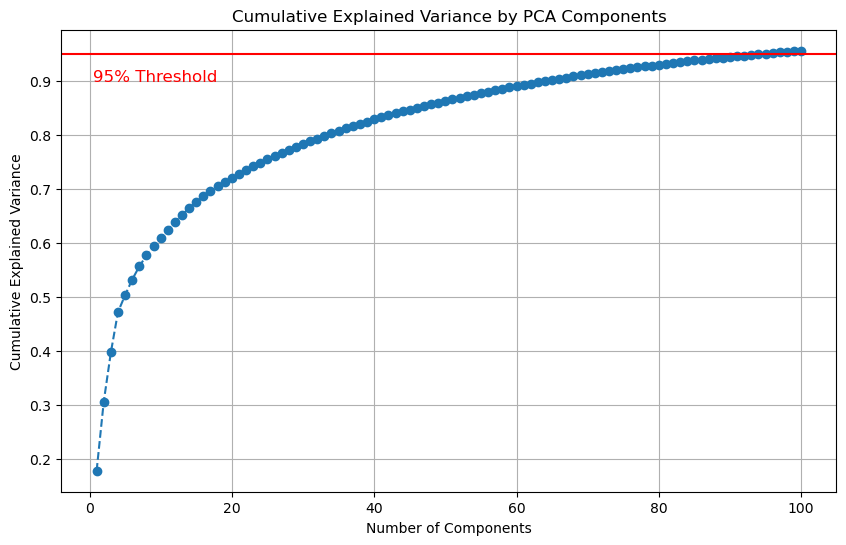

In [20]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-')  # 95% variance threshold
plt.text(0.5, 0.90, '95% Threshold', color = 'red', fontsize=12)
plt.show()

In [ ]:
there i will use lightgbm